In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [9]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


In [11]:
spark = SparkSession.builder \
    .appName('FinancialTransactionsFullAnalysis') \
    .config('spark.sql.shuffle.partitions', '8') \
    .getOrCreate()

print('Spark version:', spark.version)


Spark version: 4.0.1


In [12]:
import os

folder_path = r"C:\Users\pc\Desktop\pyspark_bda"
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created at: {folder_path}")


Folder created at: C:\Users\pc\Desktop\pyspark_bda


In [13]:
import os
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("FinancialTransactions").getOrCreate()

# Corrected file path (with raw string to handle backslashes)
csv_path = r"C:\Users\pc\Desktop\financial_transactions.csv"

# Check if file exists
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}. Upload the file and re-run the notebook.")

# Load CSV into Spark DataFrame
df = spark.read.options(
    header=True, 
    inferSchema=True, 
    nullValue='', 
    mode='DROPMALFORMED'
).csv(csv_path)

# Print shape
print("Rows:", df.count(), "Cols:", len(df.columns))

# Print schema
df.printSchema()

# Show first 5 rows as Pandas DataFrame
df.limit(5).toPandas()


Rows: 100000 Cols: 6
root
 |-- transaction_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)



,transaction_id,date,customer_id,amount,type,description
0,1,2020-10-26,926,6478.39,credit,Expect series shake art again our.
1,2,2020-01-08,466,1255.95,credit,Each left similar likely coach take.
2,3,2019-09-02,110,7969.68,debit,Direction wife job pull determine leader move ...
3,4,2020-12-02,142,2927.41,credit,Agree reveal buy black already.
4,5,2020-12-02,944,4661.88,debit,Child relationship show college whom speech.


**#Data cleaning**

**# 1. Drop exact duplicates**

In [14]:
before = df.count()
df = df.dropDuplicates()
after = df.count()
print('Dropped duplicates:', before - after)


Dropped duplicates: 0


**# 2. Inspect missing values per column**

In [16]:
from pyspark.sql.functions import col, when, count
from pyspark.sql.types import StringType

exprs = []
for c in df.columns:
    if isinstance(df.schema[c].dataType, StringType):
        exprs.append(count(when(col(c).isNull() | (col(c) == ''), c)).alias(c))
    else:
        exprs.append(count(when(col(c).isNull(), c)).alias(c))

null_counts = df.select(exprs)
null_counts.show(truncate=False)


+--------------+----+-----------+------+----+-----------+
|transaction_id|date|customer_id|amount|type|description|
+--------------+----+-----------+------+----+-----------+
|0             |0   |0          |0     |0   |0          |
+--------------+----+-----------+------+----+-----------+



**# 3. Drop columns with >50% missing (if any)**

In [18]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import col

total = df.count()
cols_to_drop = []

for c in df.columns:
    if isinstance(df.schema[c].dataType, StringType):
        nnull = df.filter(col(c).isNull() | (col(c) == '')).count()
    else:
        nnull = df.filter(col(c).isNull()).count()
        
    if nnull > 0.5 * total:
        cols_to_drop.append(c)

if cols_to_drop:
    print('Dropping columns with >50% missing:', cols_to_drop)
    df = df.drop(*cols_to_drop)



**# 4. Try to parse datetime columns**

In [19]:
date_candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
for d in date_candidates:
    try:
        df = df.withColumn(d, F.to_timestamp(F.col(d)))
        print('Parsed', d, 'to timestamp')
    except Exception as e:
        print('Could not parse', d, e)

Parsed date to timestamp


**# 5. Show schema & sample**

In [22]:
df.printSchema()
df.limit(10).toPandas()


root
 |-- transaction_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)



,transaction_id,date,customer_id,amount,type,description
0,8,2022-09-08,573,8088.01,credit,Trouble reason speak involve.
1,18,2022-05-23,296,1676.77,transfer,Property strategy represent that.
2,26,2018-09-04,531,987.32,credit,Newspaper region sister whose man fight usually.
3,35,2020-03-28,839,4914.61,transfer,Hope moment value article would economic point...
4,46,2023-03-05,410,468.79,debit,Run us scientist computer.
5,49,2021-06-27,864,592.05,transfer,Threat management consumer resource here else.
6,57,2020-05-21,919,2645.87,debit,Can thousand natural opportunity certainly.
7,62,2021-11-03,421,2253.30,debit,Put science recognize rest entire.
8,79,2018-09-05,807,9545.28,transfer,Foot idea part executive end stock want teach.
9,80,2019-04-18,48,999.02,transfer,Black read picture begin when street conference.


**# Detect likely columns: fraud label, amount, customer, merchant/type**

In [23]:
cols = df.columns
fraud_col = None
for c in cols:
    if 'fraud' in c.lower() or 'is_fraud' in c.lower() or 'isfraud' in c.lower():
        fraud_col = c
        break

amount_col = None
for c in cols:
    if 'amount' in c.lower() or 'amt' in c.lower() or 'transaction_amount' in c.lower():
        amount_col = c
        break

cust_col = None
for c in cols:
    if 'customer' in c.lower() or 'cust' in c.lower() or 'account' in c.lower():
        cust_col = c
        break

print('fraud_col:', fraud_col)
print('amount_col:', amount_col)
print('cust_col:', cust_col)


fraud_col: None
amount_col: amount
cust_col: customer_id


**# Show numeric summary for numeric columns**

In [24]:
numeric_summary = df.select([c for c, t in df.dtypes if t in ('int','bigint','double','float','long','decimal')])
if len(numeric_summary.columns) > 0:
    display(numeric_summary.describe().toPandas())


,summary,transaction_id,customer_id,amount
0,count,100000,100000,100000
1,mean,50000.5,499.59471,5009.012768299992
2,stddev,28867.657796687716,288.97350305325665,2888.443653634413
3,min,1,1,1.29
4,max,100000,1000,10000.0


**# Top 10 customers by transaction count (if cust_col found)**

In [25]:
if cust_col:
    df.groupBy(cust_col).count().orderBy(F.col('count').desc()).limit(10).show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|        853|  129|
|        802|  127|
|        222|  127|
|        115|  126|
|        476|  125|
|        523|  125|
|        943|  123|
|        573|  123|
|        781|  123|
|        720|  122|
+-----------+-----+



**# Top 10 transaction types or descriptions**

In [26]:
type_candidates = [c for c in cols if 'type' in c.lower() or 'merchant' in c.lower() or 'description' in c.lower() or 'vendor' in c.lower()]
if type_candidates:
    tcol = type_candidates[0]
    print('Using type-like column:', tcol)
    df.groupBy(tcol).count().orderBy(F.col('count').desc()).limit(20).show()


Using type-like column: type
+--------+-----+
|    type|count|
+--------+-----+
|  credit|33371|
|transfer|33331|
|   debit|33298|
+--------+-----+



**# Plotting: convert necessary slices to pandas for matplotlib**

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

**# Configure inline plotting**

In [28]:
%matplotlib inline

**# Amount distribution (sample if very large)**

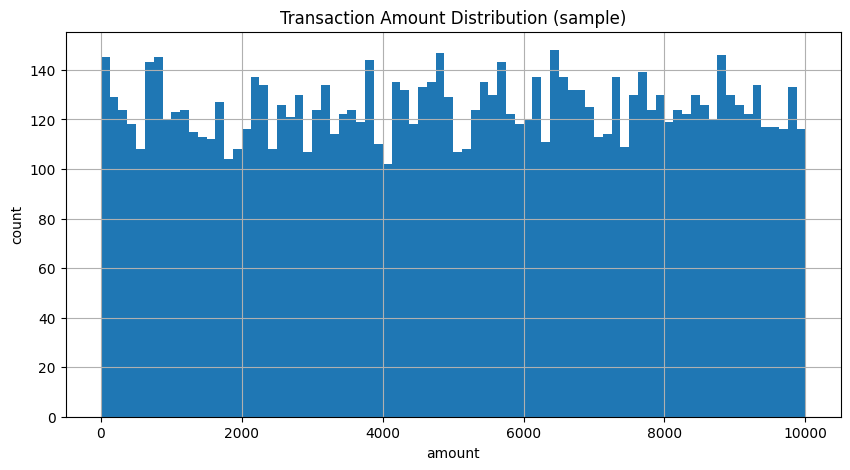

In [29]:
if amount_col:
    sample_pdf = df.select(amount_col).sample(False, 0.1, seed=42).toPandas()  # sample 10%
    plt.figure(figsize=(10,5))
    plt.hist(sample_pdf[amount_col].dropna(), bins=80)
    plt.title('Transaction Amount Distribution (sample)')
    plt.xlabel('amount')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

**# Boxplot of amount by type (if type-like col exists)**

<Figure size 1000x500 with 0 Axes>

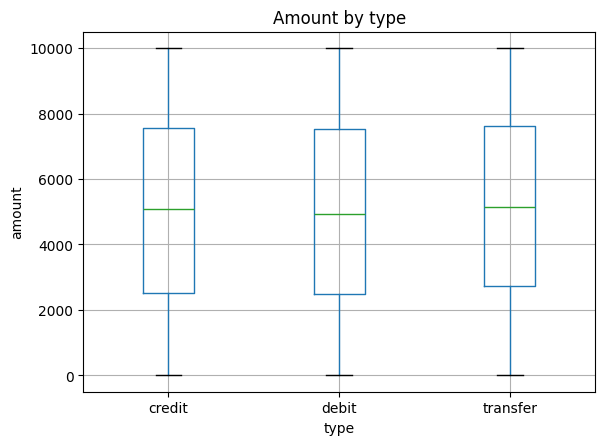

In [31]:
if amount_col and type_candidates:
    tcol = type_candidates[0]
    pdf = df.select(tcol, amount_col).sample(False, 0.1, seed=1).toPandas()
    # show top 6 categories only to keep plot readable
    top_cats = pdf[tcol].value_counts().nlargest(6).index.tolist()
    pdf = pdf[pdf[tcol].isin(top_cats)]
    plt.figure(figsize=(10,5))
    pdf.boxplot(column=amount_col, by=tcol)
    plt.title('Amount by '+tcol)
    plt.suptitle('')
    plt.xlabel(tcol)
    plt.ylabel('amount')
    plt.show()

**# Transactions over time (per day) if a date-like column exists**

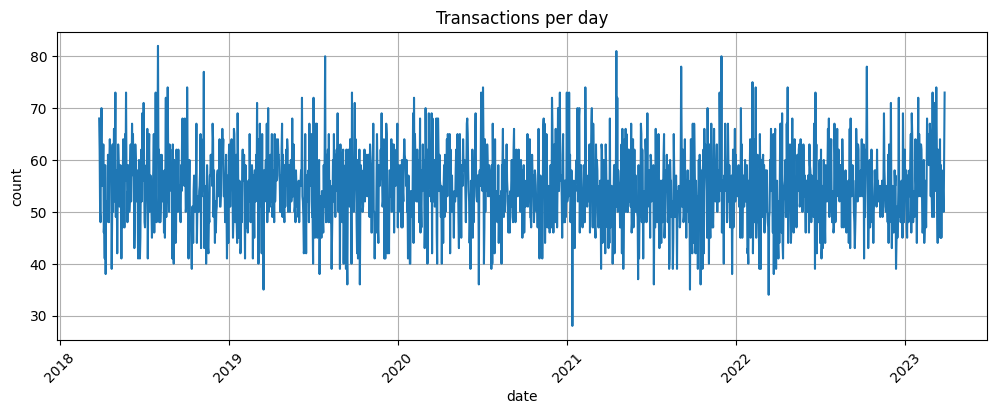

In [32]:
if date_candidates:
    dt = date_candidates[0]
    pdf = df.select(F.to_date(F.col(dt)).alias('date')).groupBy('date').count().orderBy('date').toPandas()
    if not pdf.empty:
        plt.figure(figsize=(12,4))
        plt.plot(pdf['date'], pdf['count'])
        plt.title('Transactions per day')
        plt.xlabel('date')
        plt.ylabel('count')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

**#Correlation heatmap for numeric columns (use pandas)**

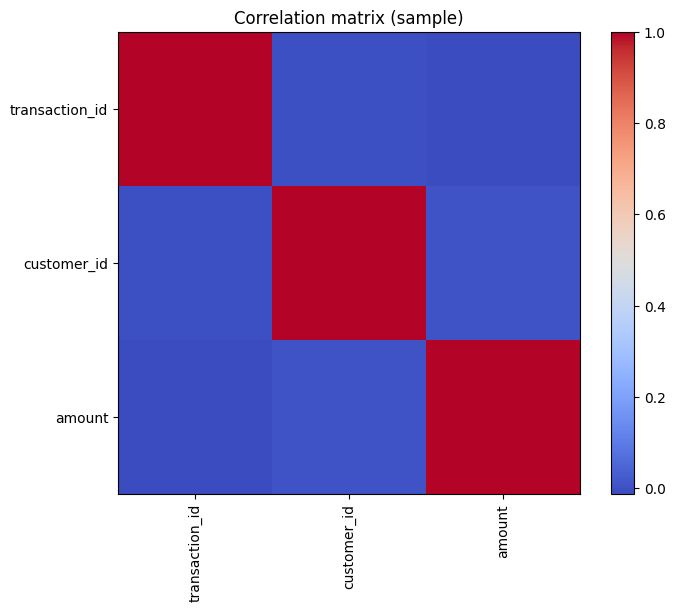

In [33]:
num_cols = [c for c, t in df.dtypes if t in ('int','bigint','double','float','long','decimal')]
if num_cols:
    pdf = df.select(num_cols).sample(False, 0.1, seed=2).toPandas()
    corr = pdf.corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation='none', cmap='coolwarm')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title('Correlation matrix (sample)')
    plt.show()


In [36]:
!pip install scikit-learn


     ---------------------------------------- 8.9/8.9 MB 2.4 MB/s eta 0:00:00
     -------------------------------------- 308.4/308.4 kB 3.8 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Anomaly detection on sample shape: (5076, 3)
Detected anomalies in sample: 51


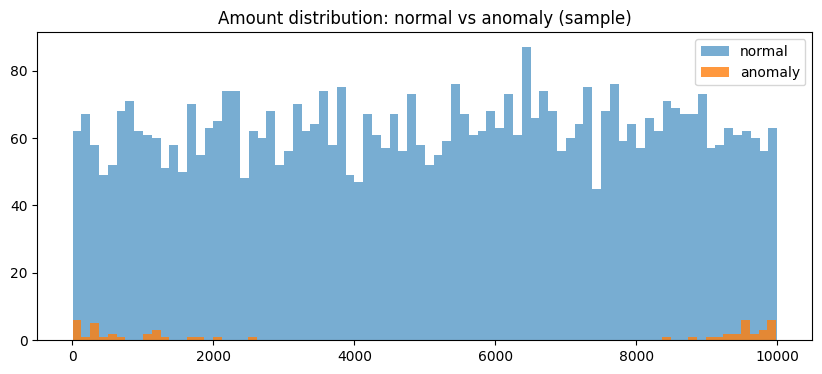

In [40]:
# Basic anomaly detection (IsolationForest) on sampled numeric features
from sklearn.ensemble import IsolationForest
import numpy as np

num_cols = [c for c, t in df.dtypes if t in ('int','bigint','double','float','long','decimal')]
if not num_cols:
    print('No numeric columns available for anomaly detection.')
else:
    # sample 5% or 20000 rows whichever smaller
    frac = min(0.05, 20000.0 / max(1, df.count()))
    sample = df.select(num_cols).sample(False, frac, seed=42).toPandas()
    sample = sample.dropna()
    print('Anomaly detection on sample shape:', sample.shape)

    # If too many columns, keep top 6 numeric columns by variance
    if sample.shape[1] > 6:
        variances = sample.var().sort_values(ascending=False)
        keep = variances.index[:6].tolist()
        sample = sample[keep]
        print('Using numeric columns:', keep)

    iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    iso.fit(sample)
    preds = iso.predict(sample)
    sample['anomaly'] = (preds == -1).astype(int)
    n_anom = sample['anomaly'].sum()
    print('Detected anomalies in sample:', n_anom)
# Show distribution of amount for anomalies if amount_col present
    if amount_col and amount_col in sample.columns:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,4))
        plt.hist(sample[sample['anomaly']==0][amount_col], bins=80, alpha=0.6, label='normal')
        plt.hist(sample[sample['anomaly']==1][amount_col], bins=80, alpha=0.8, label='anomaly')
        plt.legend()
        plt.title('Amount distribution: normal vs anomaly (sample)')
        plt.show()
